In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

from keras.preprocessing.sequence import pad_sequences

# from scikitplot.metrics import plot_confusion_matrix, plot_roc

# import transformers
# from transformers import BertModel, BertTokenizerFast
# from transformers import AdamW, AdamWeightDecay, get_linear_schedule_with_warmup

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F 

%config InlineBackend.figure_format='retina'
%matplotlib inline

sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

seed=123
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
device=torch.device('cuda:0')
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 6GB Laptop GPU'

In [3]:
#file_name ='IT-Ticket-Classification.xlsx'

import pandas as pd 
import numpy as np 
import re 
import sys
itTicketDF=pd.read_excel("../data/open_source_8500.xlsx", engine='openpyxl')
itTicketDF.head()

callers = itTicketDF['Caller'].unique() 
callers.shape
itTicketDF.drop(["Caller",'Short description'],axis=1,inplace= True)
itTicketDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       8499 non-null   object
 1   Assignment group  8500 non-null   object
dtypes: object(2)
memory usage: 132.9+ KB


In [4]:
targetClassCnt=itTicketDF['Assignment group'].value_counts()
targetClassCnt.describe()

count      74.000000
mean      114.864865
std       465.747516
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3976.000000
Name: count, dtype: float64

In [5]:
sample = itTicketDF.groupby(['Assignment group'])
regroup=[]
for grp in itTicketDF['Assignment group'].unique():
  if(sample.get_group(grp).shape[0]<10):
    regroup.append(grp)
print('Found {} groups which have under 10 samples'.format(len(regroup)))
itTicketDF['Assignment group']=itTicketDF['Assignment group'].apply(lambda x : 'misc_grp' if x in regroup  else x)

# Unique Groups check 
itTicketDF['Assignment group'].unique()

Found 25 groups which have under 10 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'misc_grp', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_44', 'GRP_45', 'GRP_47',
       'GRP_48', 'GRP_50', 'GRP_53', 'GRP_60', 'GRP_62', 'GRP_65'],
      dtype=object)

In [6]:
assignment_group_counts = itTicketDF['Assignment group'].value_counts()
assignment_group_counts.describe()

count      50.00000
mean      170.00000
std       560.13282
min        11.00000
25%        27.50000
50%        50.50000
75%       117.50000
max      3976.00000
Name: count, dtype: float64

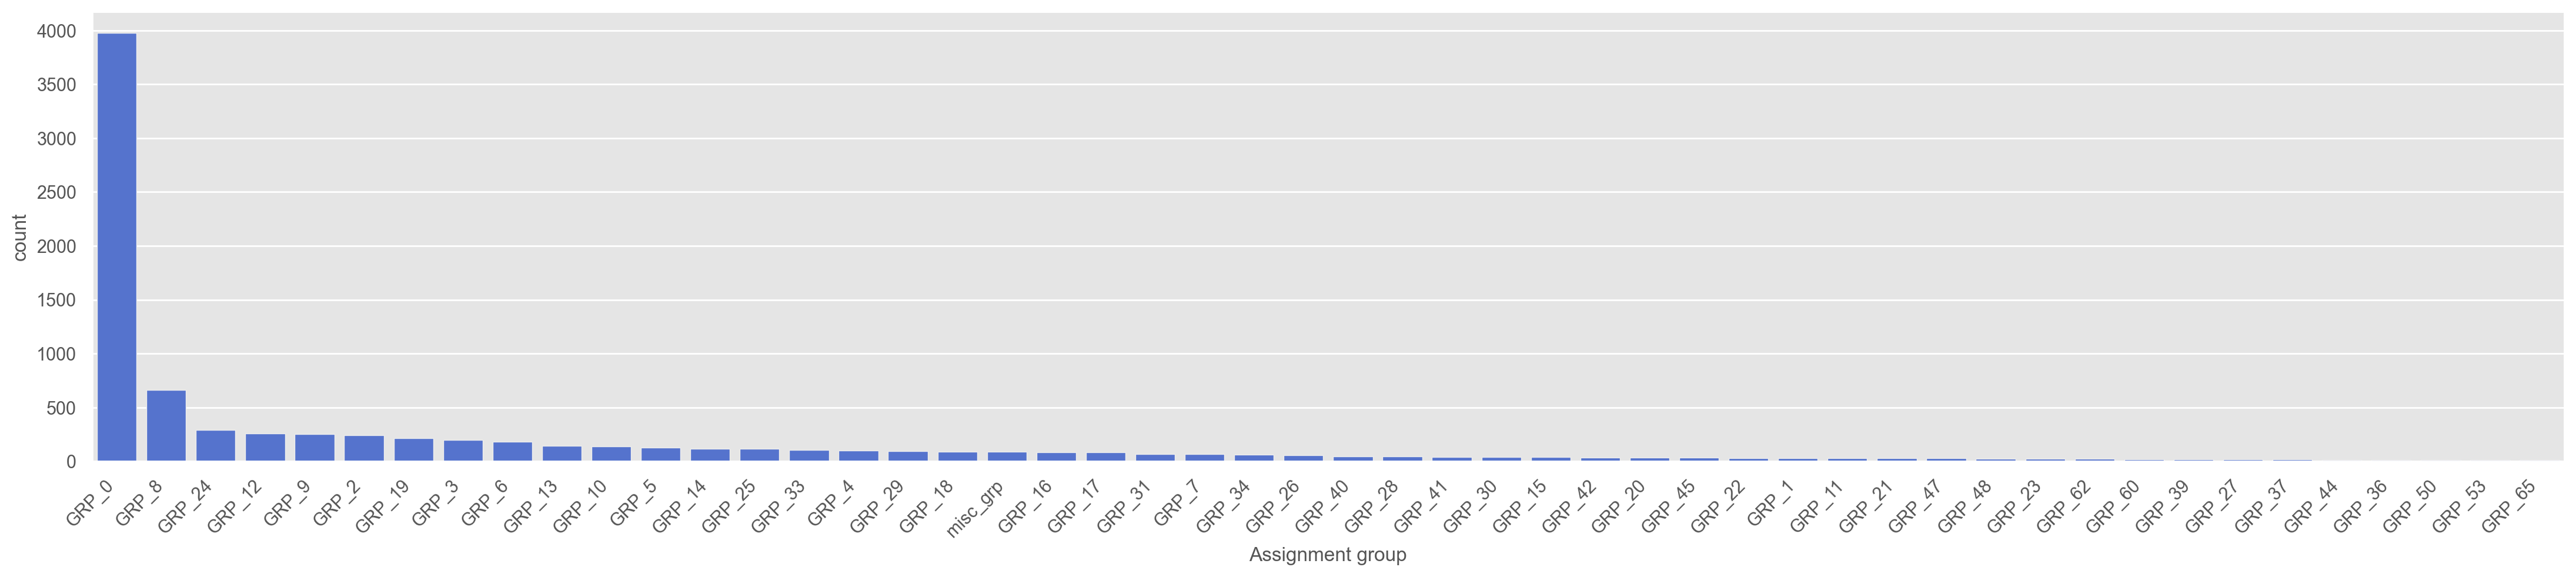

In [7]:
##Pre-Processing label Encoding on  Assignment Group
import seaborn as sns
import matplotlib.pyplot as plt
#add to remove warning for python 3.6 dependency
import warnings

plt.style.use('ggplot')
%matplotlib inline

descending_order = itTicketDF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#added code for x label rotate 
ax=sns.countplot(x='Assignment group', data=itTicketDF, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [8]:
#Fill 'Decsription' field entries that have null with blank space
itTicketDF['Description'].fillna(value=' ', inplace=True)

In [9]:
itTicketDF

,Description,Assignment group
0,-verified user details.(employee# & manager na...,GRP_0
1,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,GRP_0
2,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,GRP_0
3,unable to access hr_tool page,GRP_0
4,skype error,GRP_0
...,...,...
8495,_x000D_\n_x000D_\nreceived from: avglmrts.vhqm...,GRP_29
8496,telephony_software issue,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,GRP_0
8498,i am unable to access the machine utilities to...,GRP_62


In [10]:
from dateutil import parser
def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False

def clean_data(text):
    text=text.lower()
    text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    text = re.sub(r"received from:",' ',text)
    text = re.sub(r"from:",' ',text)
    text = re.sub(r"to:",' ',text)
    text = re.sub(r"subject:",' ',text)
    text = re.sub(r"sent:",' ',text)
    text = re.sub(r"ic:",' ',text)
    text = re.sub(r"cc:",' ',text)
    text = re.sub(r"bcc:",' ',text)
    #Remove email 
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    # Remove Non Dictionary character-TODO
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    #& 
    text = re.sub(r'&;?', 'and',text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    for name in callers:
      namelist = [part for part in name.split()]
      for namepart in namelist: 
          text = text.replace(namepart,'')
          
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text
  
itTicketDF['Description'] = itTicketDF['Description'].apply(clean_data)

In [11]:
itTicketDF

,Description,Assignment group
0,verified user details employee and manager nam...,GRP_0
1,xd xd xd hello team xd xd my meetings skype me...,GRP_0
2,xd xd xd hi xd xd cannot log on to vpn xd xd best,GRP_0
3,unable to access hr tool page,GRP_0
4,skype error,GRP_0
...,...,...
8495,xd xd xd good afternoon xd am not receiving th...,GRP_29
8496,telephony software issue,GRP_0
8497,vip windows password reset for tifpdchb pedxruyf,GRP_0
8498,i am unable to access the machine utilities to...,GRP_62


In [12]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [13]:
itTicketDF.reset_index(drop=True,inplace=True)

itTicketDF['cleanText']=itTicketDF['Description'].map(lambda s:preprocess(s))

In [15]:
itTicketDF

,Description,Assignment group,cleanText
0,verified user details employee and manager nam...,GRP_0,verified user details employee manager name ch...
1,xd xd xd hello team xd xd my meetings skype me...,GRP_0,hello team meetings skype meetings etc appeari...
2,xd xd xd hi xd xd cannot log on to vpn xd xd best,GRP_0,cannot log vpn best
3,unable to access hr tool page,GRP_0,unable access tool page
4,skype error,GRP_0,skype error
...,...,...,...
8495,xd xd xd good afternoon xd am not receiving th...,GRP_29,good afternoon receiving emails sent mail plea...
8496,telephony software issue,GRP_0,telephony software issue
8497,vip windows password reset for tifpdchb pedxruyf,GRP_0,vip windows password reset tifpdchb pedxruyf
8498,i am unable to access the machine utilities to...,GRP_62,unable access machine utilities finish drawers...


In [16]:
itTicketDF = itTicketDF[itTicketDF['cleanText'].str.strip() != '']

In [17]:
itTicketDF

,Description,Assignment group,cleanText
0,verified user details employee and manager nam...,GRP_0,verified user details employee manager name ch...
1,xd xd xd hello team xd xd my meetings skype me...,GRP_0,hello team meetings skype meetings etc appeari...
2,xd xd xd hi xd xd cannot log on to vpn xd xd best,GRP_0,cannot log vpn best
3,unable to access hr tool page,GRP_0,unable access tool page
4,skype error,GRP_0,skype error
...,...,...,...
8495,xd xd xd good afternoon xd am not receiving th...,GRP_29,good afternoon receiving emails sent mail plea...
8496,telephony software issue,GRP_0,telephony software issue
8497,vip windows password reset for tifpdchb pedxruyf,GRP_0,vip windows password reset tifpdchb pedxruyf
8498,i am unable to access the machine utilities to...,GRP_62,unable access machine utilities finish drawers...


In [18]:
from sklearn import preprocessing
def labelencoder(dataframe) : 
  label_encoder = preprocessing.LabelEncoder() 
  dataframe= label_encoder.fit_transform(dataframe)
  grp_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
  return dataframe,grp_mapping

#itTicketGRP0DF['Assignment group'] , grp_mapping_grp0= labelencoder(itTicketGRP0DF['Assignment group'])
#itTicketOthersDF_resampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(itTicketOthersDF_resampled['Assignment group'])
#otherGrpsResampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(otherGrpsResampled['Assignment group'])
#itTicketDF_resampled['Assignment group'] , grp_mapping_all_resampled= labelencoder(itTicketDF_resampled['Assignment group'])
itTicketDF['Assignment_group_label'],grp_mapping_all_raw = labelencoder(itTicketDF['Assignment group'])

<Axes: xlabel='Assignment group', ylabel='count'>

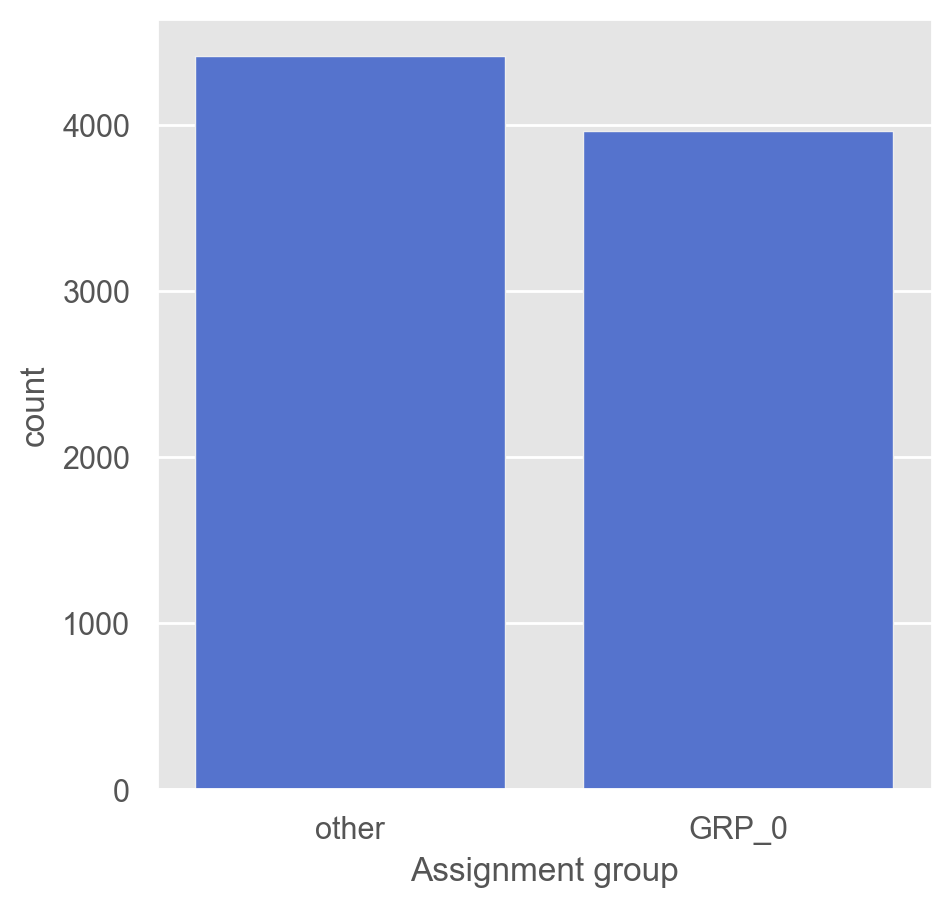

In [19]:
# Create the Dataset for classifying GRP_0
itTicketGRP0DF = itTicketDF.copy()
itTicketGRP0DF['Assignment group']=itTicketGRP0DF['Assignment group'].apply(lambda x : 'other' if x != 'GRP_0'  else x)

descending_order = itTicketGRP0DF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(5,5))
sns.countplot(x='Assignment group', data=itTicketGRP0DF, color='royalblue',order=descending_order)

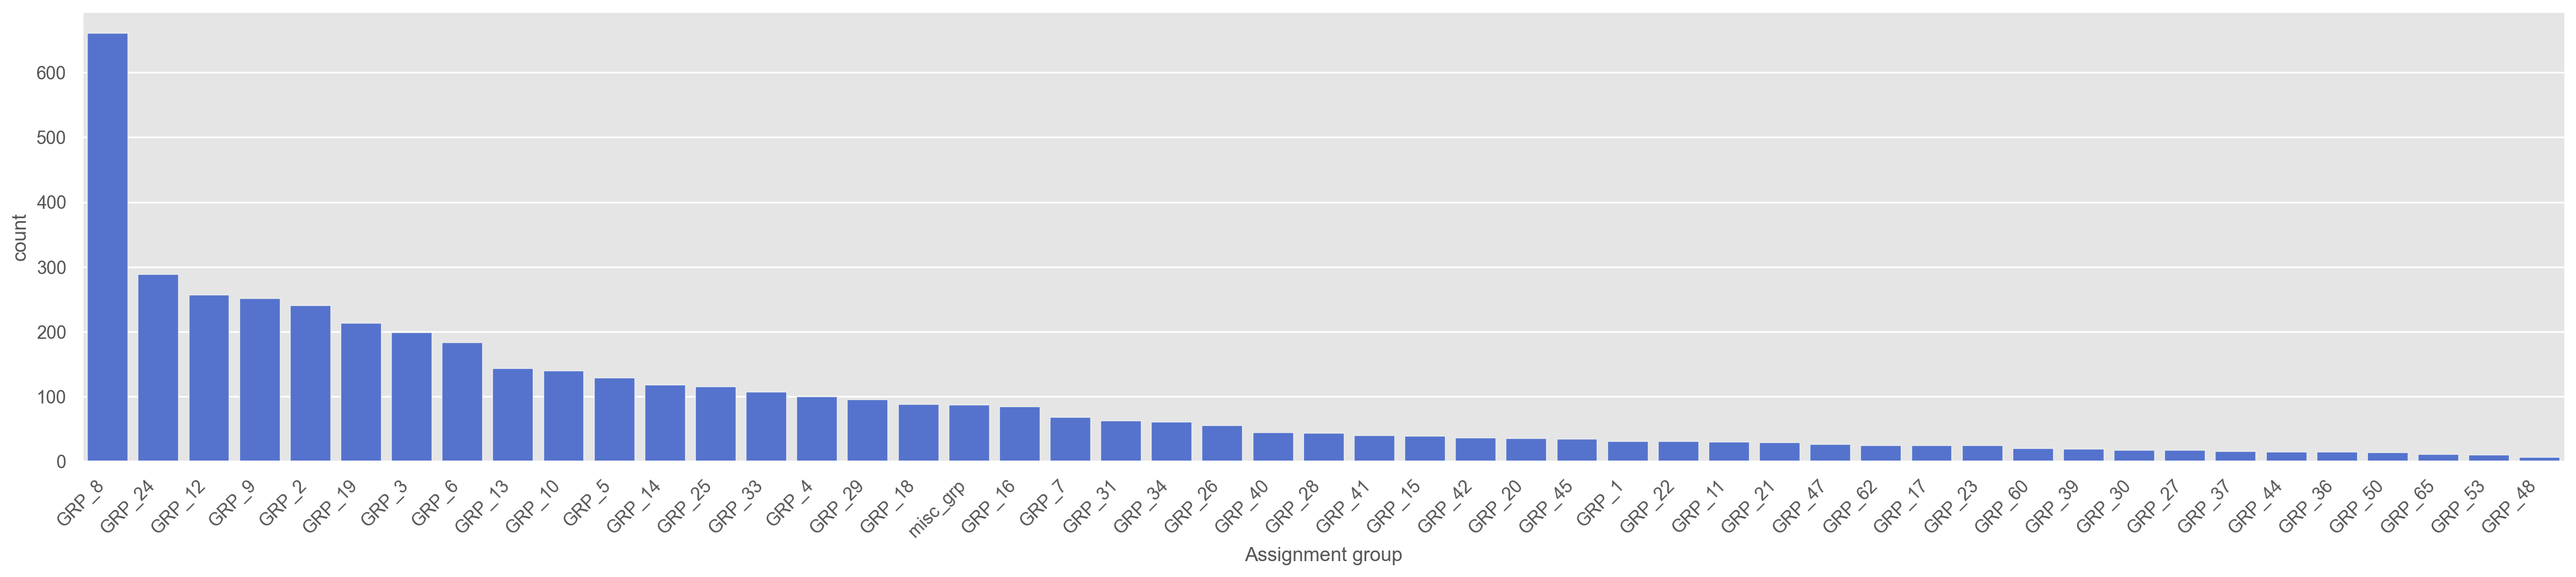

In [20]:
#Create Dataset for 'others' i.e all groups which is not part of GRP_0
itTicketOthersDF = itTicketDF[itTicketDF['Assignment group'] != 'GRP_0']

descending_order = itTicketOthersDF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=itTicketOthersDF, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [21]:
maxOthers = itTicketOthersDF['Assignment group'].value_counts().max()
maxOthers

661

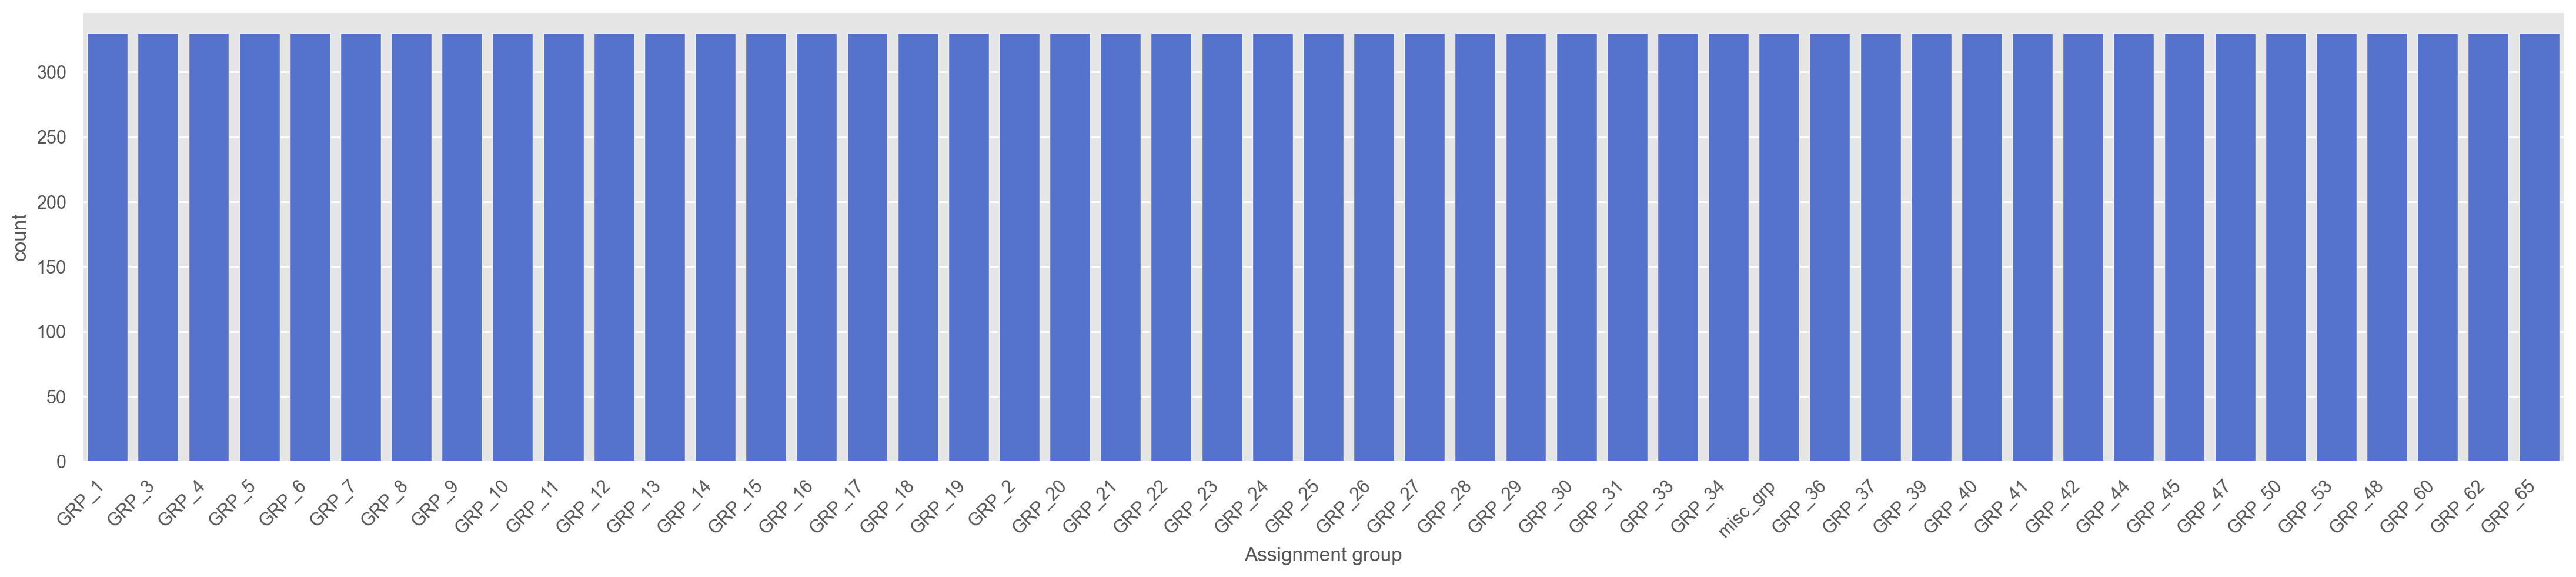

In [22]:
# Treat the imbalnce in the 'other' dataset by resampling
from sklearn.utils import resample
itTicketOthersDF_resampled = itTicketOthersDF[0:0]
for grp in itTicketOthersDF['Assignment group'].unique():
    itTicketGrpDF = itTicketOthersDF[itTicketOthersDF['Assignment group'] == grp]
    resampled = resample(itTicketGrpDF, replace=True, n_samples=int(maxOthers/2), random_state=123)
    itTicketOthersDF_resampled = pd.concat([itTicketOthersDF_resampled, resampled], ignore_index=True)
    
otherGrpsResampled = pd.concat([itTicketGRP0DF,itTicketOthersDF_resampled])
otherGrpsResampled.reset_index(inplace=True)

descending_order = itTicketOthersDF_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=itTicketOthersDF_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

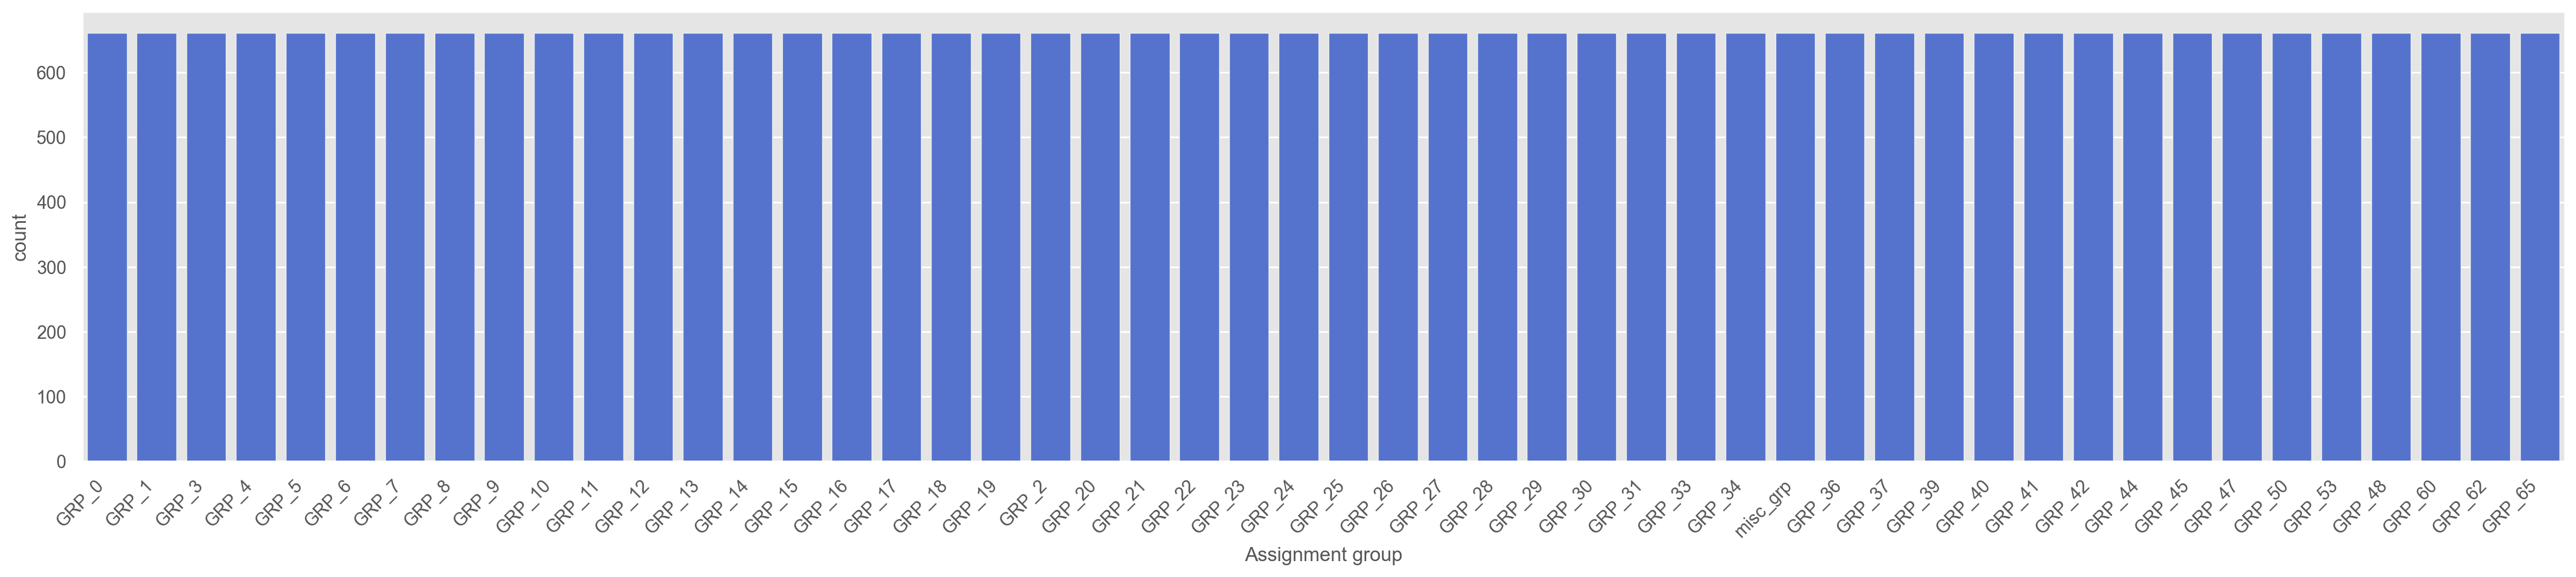

In [23]:
# Treat the imbalnce in the itTicketDF dataset by resampling to 661.This is for us to try creating a single model which use the whiole dataset & verify the performance
from sklearn.utils import resample
itTicketDF_resampled = itTicketDF[0:0]
for grp in itTicketDF['Assignment group'].unique():
    itTicketGrpDF = itTicketDF[itTicketDF['Assignment group'] == grp]
    resampled = resample(itTicketGrpDF, replace=True, n_samples=int(maxOthers), random_state=123)
    itTicketDF_resampled = pd.concat([itTicketDF_resampled, resampled], ignore_index=True)
    
descending_order = itTicketDF_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=itTicketDF_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [24]:
from sklearn import preprocessing
def labelencoder(dataframe) : 
  label_encoder = preprocessing.LabelEncoder() 
  dataframe= label_encoder.fit_transform(dataframe)
  grp_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
  return dataframe,grp_mapping

#itTicketGRP0DF['Assignment group'] , grp_mapping_grp0= labelencoder(itTicketGRP0DF['Assignment group'])
#itTicketOthersDF_resampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(itTicketOthersDF_resampled['Assignment group'])
#otherGrpsResampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(otherGrpsResampled['Assignment group'])
itTicketDF_resampled['Assignment group'] , grp_mapping_all_resampled= labelencoder(itTicketDF_resampled['Assignment group'])
#itTicketDF['Assignment group'],grp_mapping_all_raw = labelencoder(itTicketDF['Assignment group'])

In [25]:
itTicketDF_resampled

,Description,Assignment group,cleanText,Assignment_group_label
0,hello team could you please unlock account ema...,0,hello team could please unlock account email c...,0
1,xd xd xd hello xd could you please help set up...,0,hello could please help set erp user name pass...,0
2,when working in outlook cannot edit the subjec...,0,working outlook cannot edit subject line email...,0
3,erp sid account locked password reset,0,erp sid account locked password reset,0
4,i am missing one person from my gl team on the...,0,missing one person team calendar page dthyan m...,0
...,...,...,...,...
33045,good day all we need to rebuild win laptop and...,45,good day need rebuild win laptop new win image...,45
33046,observing below alert in monitoring tool since...,45,observing alert monitoring tool since monitori...,45
33047,observing below alert in monitoring tool since...,45,observing alert monitoring tool since monitori...,45
33048,when users delete the update it will run the u...,45,users delete update run update every day updat...,45


In [26]:
rows_with_nan = itTicketDF_resampled[itTicketDF_resampled['cleanText'] == '']
rows_with_nan

,Description,Assignment group,cleanText,Assignment_group_label


In [27]:
from sklearn import preprocessing
def labelencoder(dataframe) : 
  label_encoder = preprocessing.LabelEncoder() 
  dataframe= label_encoder.fit_transform(dataframe)
  grp_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
  return dataframe,grp_mapping

#itTicketGRP0DF['Assignment group'] , grp_mapping_grp0= labelencoder(itTicketGRP0DF['Assignment group'])
#itTicketOthersDF_resampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(itTicketOthersDF_resampled['Assignment group'])
otherGrpsResampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(otherGrpsResampled['Assignment group'])
itTicketDF_resampled['Assignment group'] , grp_mapping_all_resampled= labelencoder(itTicketDF_resampled['Assignment group'])
itTicketDF['Assignment group'],grp_mapping_all_raw = labelencoder(itTicketDF['Assignment group'])

In [28]:
# Using itTicketDF_resampled dataset 
df=itTicketDF_resampled

In [29]:
df

,Description,Assignment group,cleanText,Assignment_group_label
0,hello team could you please unlock account ema...,0,hello team could please unlock account email c...,0
1,xd xd xd hello xd could you please help set up...,0,hello could please help set erp user name pass...,0
2,when working in outlook cannot edit the subjec...,0,working outlook cannot edit subject line email...,0
3,erp sid account locked password reset,0,erp sid account locked password reset,0
4,i am missing one person from my gl team on the...,0,missing one person team calendar page dthyan m...,0
...,...,...,...,...
33045,good day all we need to rebuild win laptop and...,45,good day need rebuild win laptop new win image...,45
33046,observing below alert in monitoring tool since...,45,observing alert monitoring tool since monitori...,45
33047,observing below alert in monitoring tool since...,45,observing alert monitoring tool since monitori...,45
33048,when users delete the update it will run the u...,45,users delete update run update every day updat...,45


In [30]:
## 這行無效
df = df[df['cleanText'].notnull()]

In [31]:
# 移除 cleanText 欄位中為空字串的資料
df = df[df['cleanText'].str.strip() != '']

In [32]:
df['Inbound Message'] = df['cleanText']
df['Label']= df['Assignment_group_label']

In [33]:
df

,Description,Assignment group,cleanText,Assignment_group_label,Inbound Message,Label
0,hello team could you please unlock account ema...,0,hello team could please unlock account email c...,0,hello team could please unlock account email c...,0
1,xd xd xd hello xd could you please help set up...,0,hello could please help set erp user name pass...,0,hello could please help set erp user name pass...,0
2,when working in outlook cannot edit the subjec...,0,working outlook cannot edit subject line email...,0,working outlook cannot edit subject line email...,0
3,erp sid account locked password reset,0,erp sid account locked password reset,0,erp sid account locked password reset,0
4,i am missing one person from my gl team on the...,0,missing one person team calendar page dthyan m...,0,missing one person team calendar page dthyan m...,0
...,...,...,...,...,...,...
33045,good day all we need to rebuild win laptop and...,45,good day need rebuild win laptop new win image...,45,good day need rebuild win laptop new win image...,45
33046,observing below alert in monitoring tool since...,45,observing alert monitoring tool since monitori...,45,observing alert monitoring tool since monitori...,45
33047,observing below alert in monitoring tool since...,45,observing alert monitoring tool since monitori...,45,observing alert monitoring tool since monitori...,45
33048,when users delete the update it will run the u...,45,users delete update run update every day updat...,45,users delete update run update every day updat...,45


In [34]:
df.to_csv('../data/open_source_8500_preprocess_resample_33050.csv', index=False)

In [35]:
df = pd.read_csv("../data/open_source_8500_preprocess_resample_33050.csv")
df['Inbound Message'] = df['Inbound Message'].fillna("")
df

,Description,Assignment group,cleanText,Assignment_group_label,Inbound Message,Label
0,hello team could you please unlock account ema...,0,hello team could please unlock account email c...,0,hello team could please unlock account email c...,0
1,xd xd xd hello xd could you please help set up...,0,hello could please help set erp user name pass...,0,hello could please help set erp user name pass...,0
2,when working in outlook cannot edit the subjec...,0,working outlook cannot edit subject line email...,0,working outlook cannot edit subject line email...,0
3,erp sid account locked password reset,0,erp sid account locked password reset,0,erp sid account locked password reset,0
4,i am missing one person from my gl team on the...,0,missing one person team calendar page dthyan m...,0,missing one person team calendar page dthyan m...,0
...,...,...,...,...,...,...
33045,good day all we need to rebuild win laptop and...,45,good day need rebuild win laptop new win image...,45,good day need rebuild win laptop new win image...,45
33046,observing below alert in monitoring tool since...,45,observing alert monitoring tool since monitori...,45,observing alert monitoring tool since monitori...,45
33047,observing below alert in monitoring tool since...,45,observing alert monitoring tool since monitori...,45,observing alert monitoring tool since monitori...,45
33048,when users delete the update it will run the u...,45,users delete update run update every day updat...,45,users delete update run update every day updat...,45


In [36]:
df_train,df_val=train_test_split(df,test_size=0.2 ,random_state=123)  # 80% train & 10 % validation & 10% test set
df_val,df_test=train_test_split(df_val,test_size=0.5 ,random_state=123)

print('Print the shape of datasets...')
print(f'Training dataset : {df_train.shape} ')
print(f'Testing dataset : {df_test.shape}') 
print(f'Validation dataset : {df_val.shape}')

Print the shape of datasets...
Training dataset : (26440, 6) 
Testing dataset : (3305, 6)
Validation dataset : (3305, 6)


In [37]:
df['cleanText']

0        hello team could please unlock account email c...
1        hello could please help set erp user name pass...
2        working outlook cannot edit subject line email...
3                    erp sid account locked password reset
4        missing one person team calendar page dthyan m...
                               ...                        
33045    good day need rebuild win laptop new win image...
33046    observing alert monitoring tool since monitori...
33047    observing alert monitoring tool since monitori...
33048    users delete update run update every day updat...
33049    users delete update run update every day updat...
Name: cleanText, Length: 33050, dtype: object

# Model

In [38]:
from transformers import BertTokenizer, BertModel
pre_trained_BERTmodel='bert-base-uncased'
BERT_tokenizer=BertTokenizer.from_pretrained(pre_trained_BERTmodel, do_lower_case=True)

In [39]:
token_lens=[]

for message in df_train['Inbound Message']:
  tokens_message=BERT_tokenizer.encode(message, max_length=150,truncation=True)
  token_lens.append(len(tokens_message))

Text(0.5, 0, 'Token count')

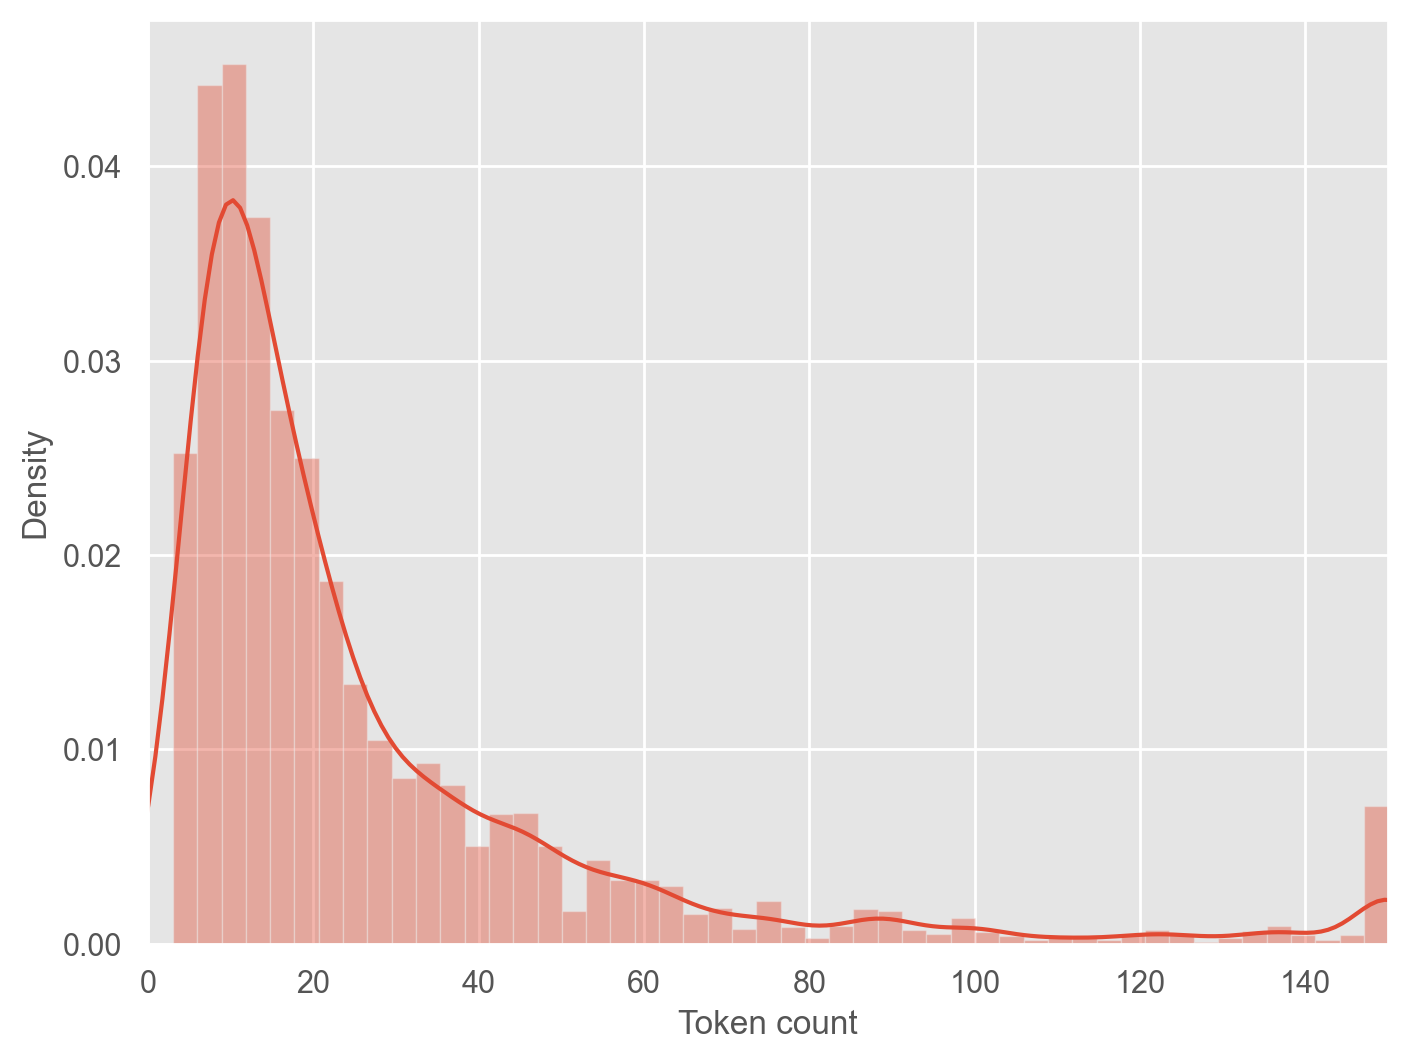

In [40]:
#Plot the tokens
plt.figure(figsize=(8,6))
sns.distplot(token_lens)
plt.xlim([0,150])
plt.xlabel('Token count')

In [41]:
class message_Dataset(Dataset):

  def __init__(self, messages, targets, tokenizer, max_length):
    self.messages=messages
    self.targets=targets
    self.tokenizer=tokenizer
    self.max_length=max_length

  def __len__(self):
    return len(self.messages)

  def __getitem__(self,item):
    message = str(self.messages[item])
    targets = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        message,
        max_length=Max_length,
        add_special_tokens=True,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
       )
           
    return {
        'message_text':message,
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(targets,dtype=torch.long)
    }

In [42]:
batch_size=8
Max_length= 35
def data_loader(df,tokenizer, max_length, batch):
  ds=message_Dataset(
      messages=df['Inbound Message'].to_numpy(),
      targets=df['Label'].to_numpy(),
      tokenizer=tokenizer,
      max_length=Max_length
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=0
  )

# Load datasets
train_DataLoader=data_loader(df_train, BERT_tokenizer,Max_length,batch_size)
test_DataLoader=data_loader(df_test, BERT_tokenizer,Max_length,batch_size)
valid_DataLoader=data_loader(df_val, BERT_tokenizer,Max_length,batch_size)

In [43]:
import time
def measure_execution_time(func, *args, **kwargs):
    import time
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    print(f"函數 {func.__name__} 運行時間: {end_time - start_time:.2f} 秒")
    return result

BERT_data = measure_execution_time(next, iter(train_DataLoader))
print(BERT_data.keys())

函數 next 運行時間: 0.02 秒
dict_keys(['message_text', 'input_ids', 'attention_mask', 'targets'])


In [44]:
#dict_keys(['message_text', 'input_ids', 'attention_mask', 'targets'])
print('Shape of the BERT_data keys...')
print(f"Input_ids : {BERT_data['input_ids'].shape}")
print(f"Attention_mask : {BERT_data['attention_mask'].shape}")
print(f"targets : {BERT_data['targets'].shape}")

Shape of the BERT_data keys...
Input_ids : torch.Size([8, 35])
Attention_mask : torch.Size([8, 35])
targets : torch.Size([8])


In [45]:
input_ids = BERT_data['input_ids'].to(device)
attention_mask = BERT_data['attention_mask'].to(device)
targets=BERT_data['targets'].to(device)
print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 35])
torch.Size([8, 35])


In [46]:
BERT_model = BertModel.from_pretrained(pre_trained_BERTmodel)
BERT_model=BERT_model.to(device)

In [47]:
n_classes=df['Label'].nunique()

In [48]:
class BERT_SentimentClassifier(nn.Module):
   def __init__(self, n_classes):
     super(BERT_SentimentClassifier, self).__init__()
     self.bert = BertModel.from_pretrained(pre_trained_BERTmodel)
     ### New layers:
     self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
     self.drop = nn.Dropout(p=float(0.6))
     self.linear = nn.Linear(256*2, n_classes)
     #self.drop1 = nn.Dropout(p=float(0.1))
     #self.hidden=nn.Linear(self.bert.config.hidden_size,256)
     #self.drop2 = nn.Dropout(p=float(0.1))
     #self.out = nn.Linear(256, n_classes)
   def forward(self, input_ids, attention_mask):
     sequence_output, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
     # sequence_output has the following shape: (batch_size, sequence_length, 768)
     lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
     hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
     output = self.drop(lstm_output)
     linear_output = self.linear(output[:,-1].view(-1,256*2)) ### We are only using the output of the last LSTM cell to perform classification

     #output = self.drop1(pooled_output)
     #output=self.hidden(output)
     #output = self.drop2(output)
     #output=self.out(output)
     return linear_output

In [49]:
BERT_model = BERT_SentimentClassifier(n_classes)
BERT_model=BERT_model.to(device)

In [50]:
F.softmax(BERT_model(input_ids,attention_mask), dim=1).to(device)

tensor([[0.0168, 0.0204, 0.0156, 0.0184, 0.0218, 0.0211, 0.0187, 0.0166, 0.0229,
         0.0207, 0.0189, 0.0203, 0.0185, 0.0183, 0.0218, 0.0170, 0.0182, 0.0229,
         0.0173, 0.0196, 0.0196, 0.0220, 0.0198, 0.0149, 0.0201, 0.0272, 0.0193,
         0.0203, 0.0199, 0.0226, 0.0207, 0.0190, 0.0243, 0.0209, 0.0200, 0.0209,
         0.0205, 0.0206, 0.0186, 0.0209, 0.0213, 0.0230, 0.0220, 0.0223, 0.0207,
         0.0152, 0.0203, 0.0174, 0.0198, 0.0199],
        [0.0176, 0.0210, 0.0180, 0.0189, 0.0229, 0.0212, 0.0198, 0.0190, 0.0199,
         0.0162, 0.0176, 0.0190, 0.0194, 0.0208, 0.0225, 0.0173, 0.0200, 0.0207,
         0.0220, 0.0178, 0.0198, 0.0205, 0.0206, 0.0180, 0.0211, 0.0195, 0.0170,
         0.0209, 0.0211, 0.0239, 0.0197, 0.0189, 0.0241, 0.0192, 0.0166, 0.0200,
         0.0252, 0.0212, 0.0200, 0.0189, 0.0192, 0.0233, 0.0181, 0.0239, 0.0170,
         0.0167, 0.0200, 0.0213, 0.0229, 0.0198],
        [0.0198, 0.0188, 0.0197, 0.0201, 0.0224, 0.0200, 0.0179, 0.0193, 0.0201,
         

In [51]:
BERT_model

BERT_SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [52]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

epochs=20
optimizer=AdamW(BERT_model.parameters(),lr=1e-5,correct_bias=False)
total_steps=len(train_DataLoader)*epochs

scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn=nn.CrossEntropyLoss().to(device)

In [53]:
def train(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_observations
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    #Feed data to BERT model
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
      )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    torch.autograd.set_detect_anomaly(True)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)     # Clip gradients to avoid exploding gradient problem
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_observations, np.mean(losses)

In [54]:
def eval_model(model, data_loader,device,loss_fn, n_observations):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      # Feed data to BERT model
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_observations, np.mean(losses)

In [39]:
#import gc
#torch.cuda.empty_cache()
#gc.collect()

In [ ]:
from tqdm.notebook import tqdm
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(epochs), desc="Epochs", dynamic_ncols=True):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    print('-' * 10)

    train_acc, train_loss = train(
        BERT_model,
        tqdm(train_DataLoader, desc="Training", leave=True, dynamic_ncols=True),
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')

    val_acc, val_loss = eval_model(
        BERT_model,
        tqdm(valid_DataLoader, desc="Validation", leave=True, dynamic_ncols=True),
        device,
        loss_fn,
        len(df_val)
    )

    print(f'Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}')

    # 更新歷史記錄
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # 保存最佳模型
    if val_acc > best_accuracy:
        torch.save(BERT_model.state_dict(), 'best_BERT_model_state_itTicketDF_resampled_gpu.bin')
        best_accuracy = val_acc

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20
----------


Training:   0%|          | 0/3160 [00:00<?, ?it/s]

In [27]:
from datetime import datetime
save_directory = '../models/'  # 設定保存目錄

current_date = datetime.now()
# 格式化日期為 "YYYY_MMDD" 格式
formatted_date = current_date.strftime('%Y-%m-%d')

# 保存模型的權重、配置檔案和 tokenizer
BERT_model.bert.save_pretrained(save_directory + formatted_date + '_重現paper實驗_resample至33050')  # 保存 BERT 模型（包含 config 和 weights）
BERT_tokenizer.save_pretrained(save_directory + formatted_date + '_重現paper實驗_resample至33050')  # 保存 tokenizer

('../models/2024_1216_重現paper實驗\\tokenizer_config.json',
 '../models/2024_1216_重現paper實驗\\special_tokens_map.json',
 '../models/2024_1216_重現paper實驗\\vocab.txt',
 '../models/2024_1216_重現paper實驗\\added_tokens.json')

In [41]:
#train_acc

In [42]:
#plt.figure(figsize=(12,6))
#plt.plot(history['train_acc'], label='train accuracy')
#plt.plot(history['val_acc'], label='validation accuracy')
#plt.title('Training history')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend()
#plt.ylim([0, 1]);

In [28]:
def get_predictions(model, data_loader):
  model = model.eval()
  messages = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["message_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      messages.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return messages, predictions, prediction_probs, real_values

In [29]:
messages, y_pred, y_pred_probs, y_test = get_predictions(
  BERT_model,
  test_DataLoader
)

In [34]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from scipy import interp

y_true = y_test # ground truth labels
y_probas = y_pred_probs # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probas )
plt.gca().get_legend().remove()
plt.savefig('itTicketDF_resampled_epoch20.pdf', bbox_inches='tight')
plt.savefig('itTicketDF_resampled_epoch20.pdf.png', bbox_inches='tight')
plt.show()


ImportError: cannot import name 'interp' from 'scipy' (D:\Anaconda3\envs\cuda\Lib\site-packages\scipy\__init__.py)

In [39]:
# Calculate precision, recall, f1_score, & roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
precision_b, recall_b, f1_score_b, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy_b = accuracy_score(y_test, y_pred)
print(f'Precision for BERT : {round(precision_b,2)}')
print(f'Recall for BERT : {round(recall_b,2)}')
print(f'F1_score for BERT : {round(f1_score_b,2)}')
print(f'Accuracy score for BERT : {round(accuracy_b,2)}')

Precision for BERT : 0.94
Recall for BERT : 0.9
F1_score for BERT : 0.91
Accuracy score for BERT : 0.9


In [40]:
class_report=classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.93      0.77      0.85        71
           1       0.81      1.00      0.90        69
           2       0.97      0.93      0.95        73
           3       1.00      1.00      1.00        70
           4       0.92      0.80      0.86        60
           5       0.98      0.97      0.98        64
           6       0.99      0.97      0.98        68
           7       1.00      1.00      1.00        55
           8       1.00      1.00      1.00        63
           9       1.00      0.31      0.48        64
          10       0.98      1.00      0.99        56
          11       0.88      0.93      0.90        56
          12       0.93      0.91      0.92        74
          13       1.00      1.00      1.00        66
          14       1.00      1.00      1.00        67
          15       0.97      1.00      0.98        65
          16       0.97      1.00      0.99        76
          17       0.98    

----------------------------